#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

#Data preparation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Let us split the images in two groups, according to their label.

In [4]:
# Split training data into train and validation sets
val_split = 0.1
num_val_samples = int(cifar10_x_train.shape[0] * val_split)

cifar10_x_val = cifar10_x_train[:num_val_samples]
cifar10_y_val = cifar10_y_train[:num_val_samples]

cifar10_x_train = cifar10_x_train[num_val_samples:]
cifar10_y_train = cifar10_y_train[num_val_samples:]

# Separate data into two groups for training
cond_1_train = cifar10_y_train[:, 0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1_train]
cifar10_y_train_1 = cifar10_y_train[cond_1_train]

cond_2_train = cifar10_y_train[:, 0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2_train]
cifar10_y_train_2 = cifar10_y_train[cond_2_train]

# Separate validation data into two groups
cond_1_val = cifar10_y_val[:, 0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:, 0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

# Separate test data into two groups
cond_1_test = cifar10_y_test[:, 0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:, 0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]


Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [5]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [6]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: automobile, second = frog


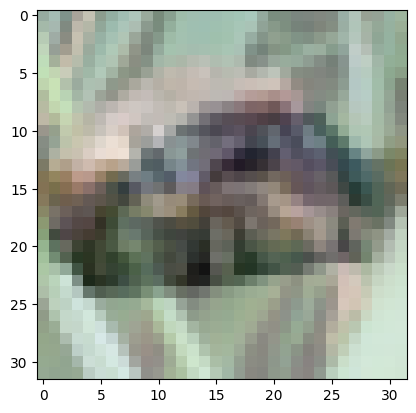

In [7]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [8]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [9]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [10]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [11]:
eval_model(random_model)

0.19840000000000002

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [12]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.20007000000000003
standard deviation =  0.0038032354647063327


### **Summary of the model:** CNN

This is the most successful model, a Convolutional Neural Network, that was created in order to solve the task given.
The architecture consists of:
1. **Input layer**
- Shape: (32, 32, 3), which is suitable for small image datasets like CIFAR-10
2. **Resize layer**
- This is a preprocessing step that adjusts the input data dimensions. However, a try of resizing to 224 proved to be not performing well, so the initial dimensions of 32 were kept at the end.
3. **Convolutional Blocks**
- There are 5 sequential convolutional blocks with:
- A Conv2D layer with an increasing number of filters: 64 -> 128 -> 256 -> 512 -> 1024
- A kernel size of (3,3) and a padding = 'same' preserve the spatial dimensions
- Batch normalization to stabilize and normalize feature distributions
- Swish activation for non-linearity
- A MaxPooling2D layer with (1,1) strides, which does not reduce spatial dimensions
- These blocks allow to progressively extract higher-level features
4. **Global Average Pooling**
- A GlobalAveragePooling2D layer reduces the spatial dimensions of the feature maps to a 1D vector ((None, 1024)), summarizing spatial information
5. **Fully Connected Layers**
- Two parallel branches for output1 and output2:
- A dense layer with 1024 units and no activation, followed by a LeakyReLU activation (alpha=0.1) for non-linearity
- Dropout (0.2) was added for regularization to prevent overfitting
- A final dense layer with 5 units and a softmax activation for classification
6. **Outputs**
- output1 and output2: Two separate predictions, each targeting 5 classes

In [13]:
# Resize CIFAR-10 images
# resize_layer = layers.Lambda(lambda x: tf.image.resize(x, (224, 224)))
resize_layer = layers.Lambda(lambda x: tf.image.resize(x, (32, 32)))

In [15]:
def enhanced_cnn_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = resize_layer(inputs)

    # First convolutional block
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Second convolutional block
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Third convolutional block
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Fourth convolutional block
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Fifth convolutional block
    x = layers.Conv2D(1024, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers for output 1
    fc1_output1 = layers.Dense(1024, activation=None)(x)
    fc1_output1 = layers.LeakyReLU(alpha=0.1)(fc1_output1)
    fc1_output1 = layers.Dropout(0.2)(fc1_output1)
    output1 = layers.Dense(5, activation='softmax', name='output1')(fc1_output1)

    # Fully connected layers for output 2
    fc1_output2 = layers.Dense(1024, activation=None)(x)
    fc1_output2 = layers.LeakyReLU(alpha=0.1)(fc1_output2)
    fc1_output2 = layers.Dropout(0.2)(fc1_output2)
    output2 = layers.Dense(5, activation='softmax', name='output2')(fc1_output2)

    model = Model(inputs=inputs, outputs=[output1, output2])
    return model


**Label Smoothing Loss**
- The implementation of Label Smoothing Loss introduces smoothing to the target labels, aiming to reduce overconfidence in predictions and improve generalization.
- It was implemented as a subclass of tf.keras.losses.Loss

In [16]:

class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def call(self, y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_pred)[-1], tf.float32)
        smooth_positives = 1.0 - self.smoothing
        smooth_negatives = self.smoothing / num_classes
        y_true_smoothed = y_true * smooth_positives + smooth_negatives
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true_smoothed, y_pred))



**Learning Rate Scheduler**
- The learning rate scheduler that was used implements an Exponential Decay strategy, where the learning rate decreases exponentially over time
- Initial Learning Rate starts at: 0.001
- Decay Steps: The learning rate is updated every 5*500 = 2500 steps
- Decay Rate: After every 2500 steps, the lr is multiplied by 0.8, reducing it by 20%
- Staircase Decay: the staircase=True setting ensures that the lr decreases in descrete steps rather than continuously
- This learning rate scheduler strategy gradually reduces the learning rate as training progresses, allowing the model to make large updates in the early stages and smaller, more fine-tuned updates later. It helps improve convergence and reduces the risk of overshooting the optimal solution.

In [17]:
# Define learning rate scheduler
initial_lr = 0.001
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps= 5 * 500,
    decay_rate=0.8,
    staircase=True
)

**Optimizer with layer-specific learning rate**
This is a custom implementation of the Adam optimizer which allows each layer in the model to have a distinct learning rate, providing fine-grained control over the training process.
1. Custom Adam Optimizer
- Inherits from: tf.keras.optimizers.Adam
- Accepts a dictionary lr_multipliers, mapping specific layers to their specific learning rate multipliers
- Overrides the _resource_apply_dense method to scale the learning rate for each layer by its specified multiplier
2. Layer-Specific Learning Rate Multipliers
- lr_multipliers assigns lower learning rates to early layers(1e-5), moderate rates to middle layers(1e-4), and higher rates to late layers and dense layers (1e-3).If we apply lower LR for the lower layers, we can preserve the general features. If we apply higher LR for the higher layers, we can help the model fine-tune more aggressively and adapt to the specifics
- Inspiration about this method was taken from this blog: https://kharshit.github.io/blog/2019/03/22/layer-specific-learning-rates

3. Integration with Learning Rate Scheduler:
- The learning_rate parameter uses the ExponentialDecay scheduler, ensuring the base learning rate decreases over time while still respecting the layer-specific multipliers.


In [18]:
# Define the optimizer with layer-specific learning rates
class CustomAdam(tf.keras.optimizers.Adam):
    def __init__(self, lr_multipliers, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr_multipliers = lr_multipliers

    def _resource_apply_dense(self, grad, var, apply_state=None):
        multiplier = self.lr_multipliers.get(var.name, 1.0)
        scaled_lr = self._get_hyper("learning_rate") * multiplier
        self._set_hyper("learning_rate", scaled_lr)
        return super()._resource_apply_dense(grad, var, apply_state)

lr_multipliers = {
    'conv2d/kernel:0': 1e-5,    # Early layers
    'conv2d_1/kernel:0': 1e-5,  # Early layers
    'conv2d_2/kernel:0': 1e-4,  # Middle layers
    'conv2d_3/kernel:0': 1e-4,  # Middle layers
    'conv2d_4/kernel:0': 1e-3,  # Late layers
    'conv2d_5/kernel:0': 1e-3,  # Late layers
    'dense/kernel:0': 1e-3,     # Final dense layers
    'dense_1/kernel:0': 1e-3
}

# Compile the model with a custom optimizer
custom_optimizer = CustomAdam(
    learning_rate=scheduler,
    lr_multipliers=lr_multipliers
)

**Train the model**
1. Model Definition
- enhanced_cnn_model() is compiled with the custom optimizer defined before that incorporates layer-specific learning-rate multipliers and an exponenitial decay scheduler
- Loss: LabelSmoothingLoss with a smoothing factor of 0.1 was applied independently to the two outputs
- Metrics: Accuracy was used to evaluate the performance of each output
2. Data Generators
- train_gen and val_gen were used to dynamically generate training and validation batches of size 64
3. Model Training
- model.fit() trains the model for 120 epochs, using 500 steps per epoch for training and 100 steps per epoch for validation
- This trainig process evaluates the model on the validation set after each epoch to monitor its performance

In [19]:
model = enhanced_cnn_model()
model.compile(
    optimizer=custom_optimizer,
    loss={'output1': LabelSmoothingLoss(smoothing=0.1), 'output2': LabelSmoothingLoss(smoothing=0.1)},
    metrics={'output1': 'accuracy', 'output2': 'accuracy'}
)

train_gen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, 64)
val_gen = datagenerator(cifar10_x_val_1, cifar10_x_val_2, cifar10_y_val_1, cifar10_y_val_2, 64)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=120,
    validation_data=val_gen,
    validation_steps=100
)



Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - loss: 2.9988 - output1_accuracy: 0.3642 - output1_loss: 1.5181 - output2_accuracy: 0.3854 - output2_loss: 1.4807 - val_loss: 3.5619 - val_output1_accuracy: 0.2700 - val_output1_loss: 1.8005 - val_output2_accuracy: 0.2975 - val_output2_loss: 1.7614
Epoch 2/120
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 2.6600 - output1_accuracy: 0.4434 - output1_loss: 1.3801 - output2_accuracy: 0.5185 - output2_loss: 1.2799 - val_loss: 3.0147 - val_output1_accuracy: 0.2961 - val_output1_loss: 1.8222 - val_output2_accuracy: 0.5723 - val_output2_loss: 1.1926
Epoch 3/120
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 2.5106 - output1_accuracy: 0.4836 - output1_loss: 1.3280 - output2_accuracy: 0.5823 - output2_loss: 1.1826 - val_loss: 3.2080 - val_output1_accuracy: 0.4334 - val_output1_loss: 1.4675 - val_output2_accuracy: 0.4022 - val_output2_loss: 1.7404
Epoch 4/120
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 2.4113 - output1_accuracy: 0.5025 

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu (Silu)               │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ silu[0][0]             │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_1 (Silu)             │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ silu_1[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_2 (Silu)             │ (None, 32, 32, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ silu_2[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 25,155,999 (95.96 MB)

 Trainable params: 8,384,010 (31.98 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 16,768,021 (63.96 MB)

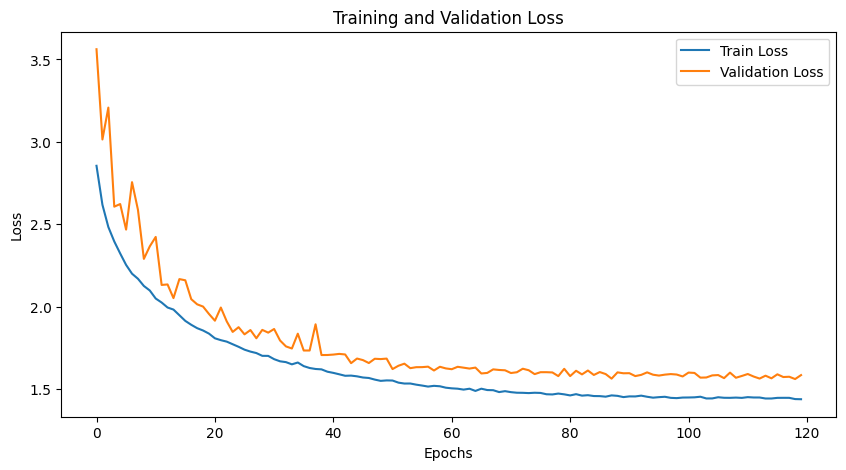

In [29]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

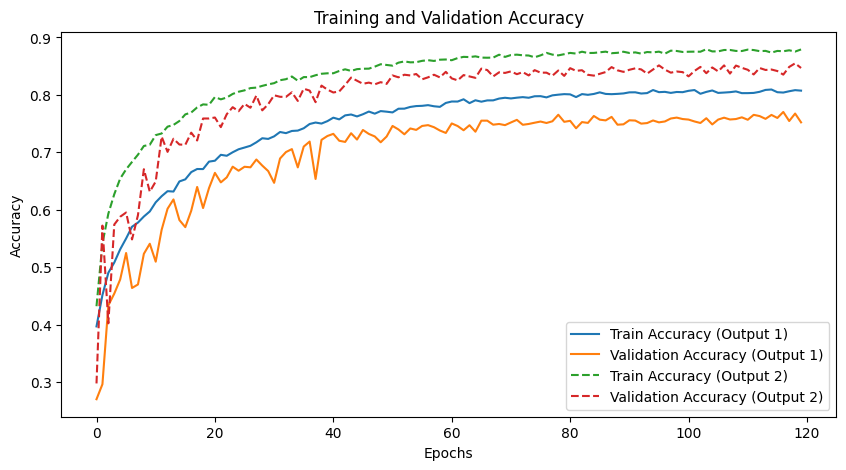

In [32]:
# Plot training and validation accuracy for each output
plt.figure(figsize=(10, 5))
plt.plot(history.history['output1_accuracy'], label='Train Accuracy (Output 1)')
plt.plot(history.history['val_output1_accuracy'], label='Validation Accuracy (Output 1)')
plt.plot(history.history['output2_accuracy'], label='Train Accuracy (Output 2)', linestyle='dashed')
plt.plot(history.history['val_output2_accuracy'], label='Validation Accuracy (Output 2)', linestyle='dashed')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
# Save the model weights
model.save_weights("enhanced_cnn_best_model.weights.h5")

In [22]:
def eval_model(model):
    testgen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 10000)
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    pred1 = np.argmax(predictions[0], axis=1)
    pred2 = np.argmax(predictions[1], axis=1)
    correct_guesses_1 = pred1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred2 == np.argmax(eval_samples_y[1], axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("Mean accuracy =", np.mean(eval_results))
print("Standard deviation =", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean accuracy = 0.7966399999999999
Standard deviation = 0.0032478300448145715


### **`Additional exploration and work:`** For fine-tuning the model Transfer learning can be applied

# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

